# Pràctica 2: Classificació

- Grup: GPA305-1030 Compossat per: Jorge Giménez, Juan Carlos Soriano i Roger Boadella (1493035, 1493037, 1494330)
- Link al dataset 1 (Apartat B): https://www.kaggle.com/kyr7plus/emg-4
- Link al dataset 2 (Apartat A): https://www.kaggle.com/andradaolteanu/gtzan-dataset-music-genre-classification

## Apartat B: Classificació Numèrica

### 1. Imports i preprocessament de les dades

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
columns = []
for readingIdx in range(1,9):
    for sensorIdx in range(1, 9):
        columns.append(f'r{readingIdx}-s{sensorIdx}')
columns.append('gesture')
data = pd.DataFrame(columns=columns)

dataset_path = "./data/"
dataset_files = ["0", "1", "2", "3"]
for file in dataset_files:
    df = pd.read_csv(f'{dataset_path}{file}.csv', names=columns)
    data = data.append(df)

El dataset ve donat en 4 fitxers csv, el que fem en aquest bloc de codi és junta-los tots en un sol dataset així com donar uns noms més pràctics a les columnes. De totes maneres, l'estructura del dataset serà explicada a continuació.

### 2. Explanatory Data Analysis

El nostre dataset tracta de diferents gests que es fan amb una mà. Es col·loquen diferents sensors en una mà humana i es realitzen un total de 8 gests diferents. A la vegada hi ha 8 sensors diferents que fan lectures de l'activitat elèctrica produïda pels músculs amb una freqüència de 200Hz.  
Disposem de 65 columnes al dataset i un total d'11678 files. Les primeres 64 columnes són les 8 lectures consecutives que realitzen els 8 sensors en un temps de lectura de 20ms. En quant a l'última fila, aquesta conté l'etiqueta que ens diu quin gest està fent la mà per a cada conjunt de lectures. Aquesta etiqueta pot ser:  
- 0: Pedra
- 1: Paper
- 2: Tisores
- 3: OK  

Els noms de les columnes tenen el següent format r[X]-s[Y] on X és el número de lectura (1-8) i Y és el número del sensor (1-8).

In [3]:
data.head()

r1-s1  r1-s2  r1-s3  r1-s4   r1-s5   r1-s6    r1-s7   r1-s8   r2-s1  \
0  26.000  4.000  5.000  8.000  -1.000 -13.000 -109.000 -66.000  -9.000   
1 -47.000 -6.000 -5.000 -7.000  13.000  -1.000   35.000 -10.000  10.000   
2 -19.000 -8.000 -8.000 -8.000 -21.000  -6.000  -79.000  12.000   0.000   
3   2.000  3.000  0.000  2.000   0.000  22.000  106.000 -14.000 -16.000   
4   6.000  0.000  0.000 -2.000 -14.000  10.000  -51.000   5.000   7.000   

   r2-s2  ...   r7-s8   r8-s1  r8-s2  r8-s3  r8-s4   r8-s5   r8-s6    r8-s7  \
0  2.000  ... -28.000  61.000  4.000  8.000  5.000   4.000  -7.000  -59.000   
1 -4.000  ... -25.000  47.000  6.000  6.000  5.000  13.000  21.000  111.000   
2  5.000  ... -83.000   7.000  7.000  1.000 -8.000   7.000  21.000  114.000   
3 -2.000  ... -38.000 -11.000  4.000  7.000 11.000  33.000  39.000  119.000   
4  0.000  ...  38.000 -35.000 -8.000  2.000  6.000 -13.000 -24.000 -112.000   

    r8-s8  gesture  
0  16.000        0  
1  15.000        0  
2  48.000        0  
3  43.000        0  
4 -69.000        0  

[5 rows x 65 columns]

Tots els atributs contenen valors enters. N'hi ha de positius i n'hi ha de negatius.

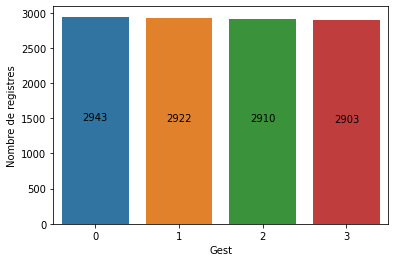

In [4]:
ax = sns.barplot(x=data['gesture'].unique(), y=data['gesture'].value_counts());
plt.xlabel("Gest");
plt.ylabel("Nombre de registres");
for p in ax.patches:
            _x = p.get_x()+p.get_width()/2
            _y = p.get_y()+p.get_height()/2
            value = '{:.0f}'.format(p.get_height())
            ax.text(_x, _y, value, ha="center")

Tenim una distribució molt balancejada dels gests. 2943 registres per a la "pedra", 2922 per al "paper", 2910 per al "tisores" i 2903 per al "OK". Per tant, podem utilitzar l'accuracy per avaluar el nostre model, ja que totes les classes estan balancejades. A més, el modelo no hauria de desenvolupar 'bias' cap a cap de les classes.

In [5]:
nullValues = 0
for n in data.isna().sum():
    if n != 0: nullValues += 1
print(f'Nombre de "missing-values": {nullValues}')

Nombre de "missing-values": 0


No hi ha "missing-values" a cap lloc, cosa positiva ja que així no els hem de tractar de cpa manera.

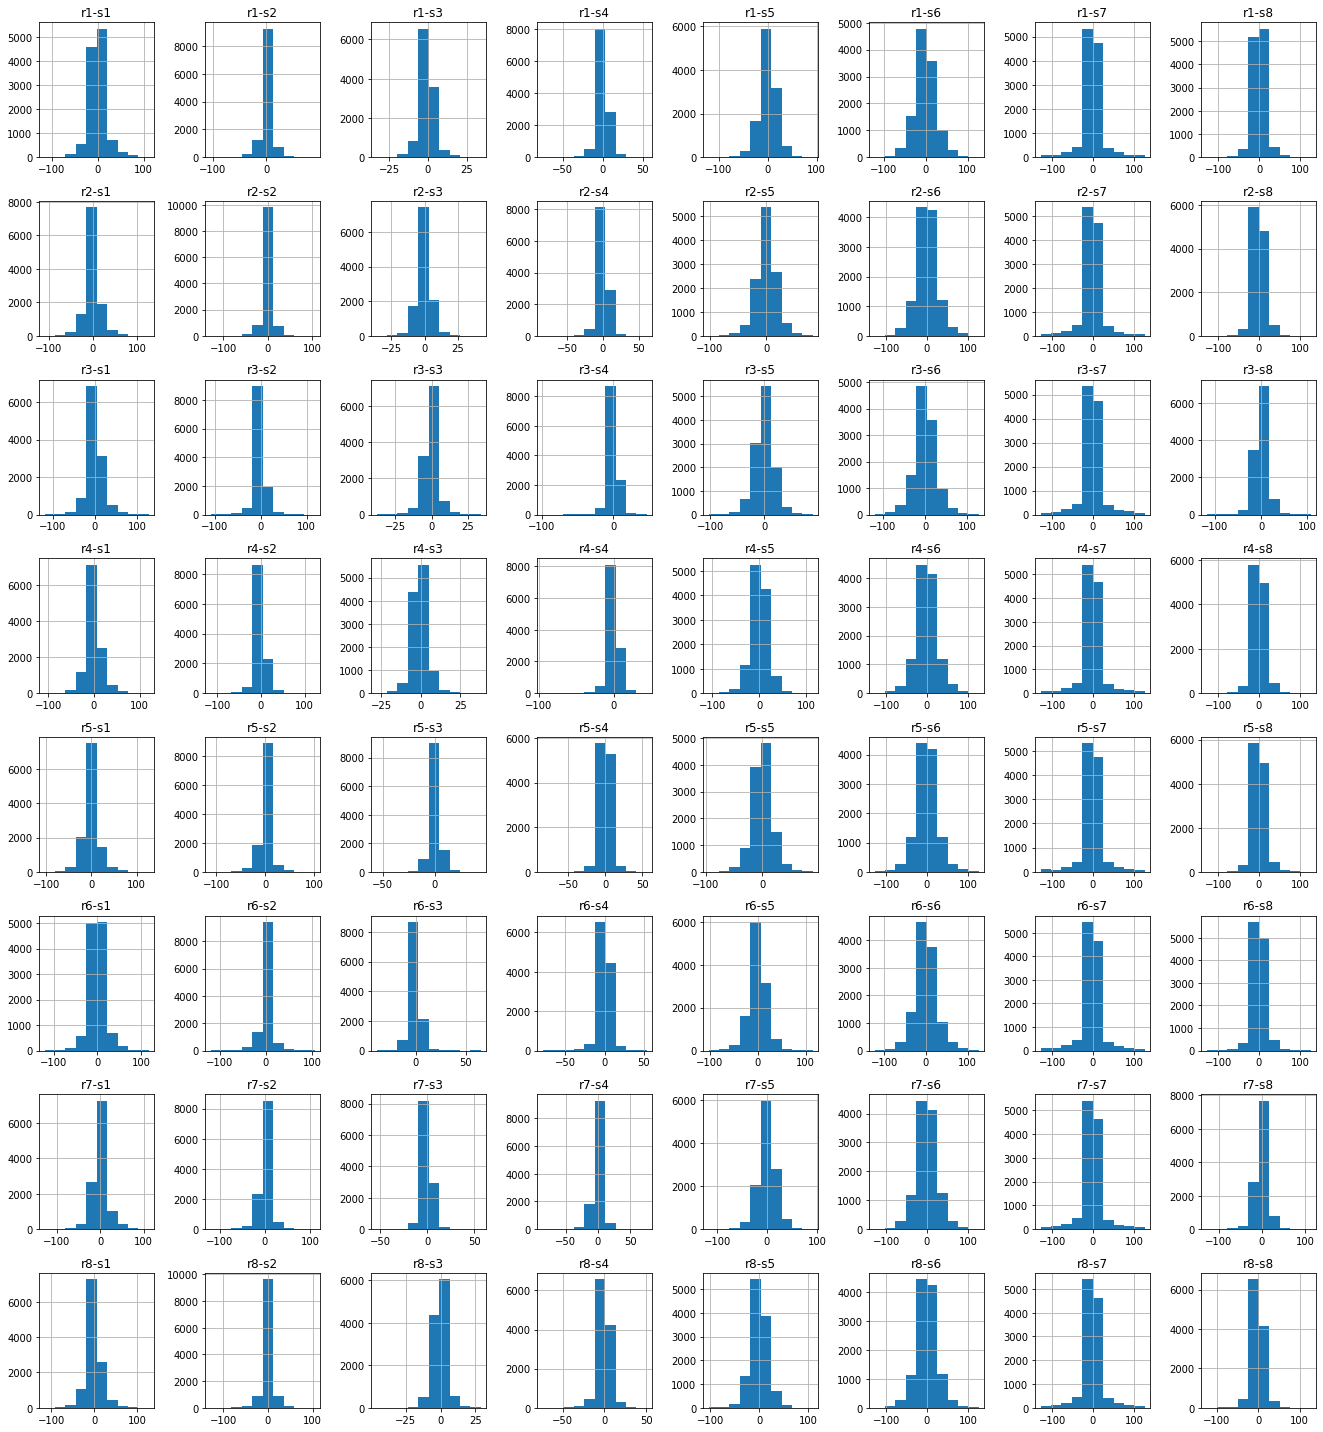

In [6]:
data.hist();
fig = plt.gcf()
fig.set_size_inches(18.5, 20)
plt.tight_layout()

Totes les lectures de tots els sensors tenen distribucions més o menys sembalnts, però pdoem observar com el rang de valors d'alguns sensors són més grans que els d'altres, per tant no està de més normalitzar aquestes dades més endevant.

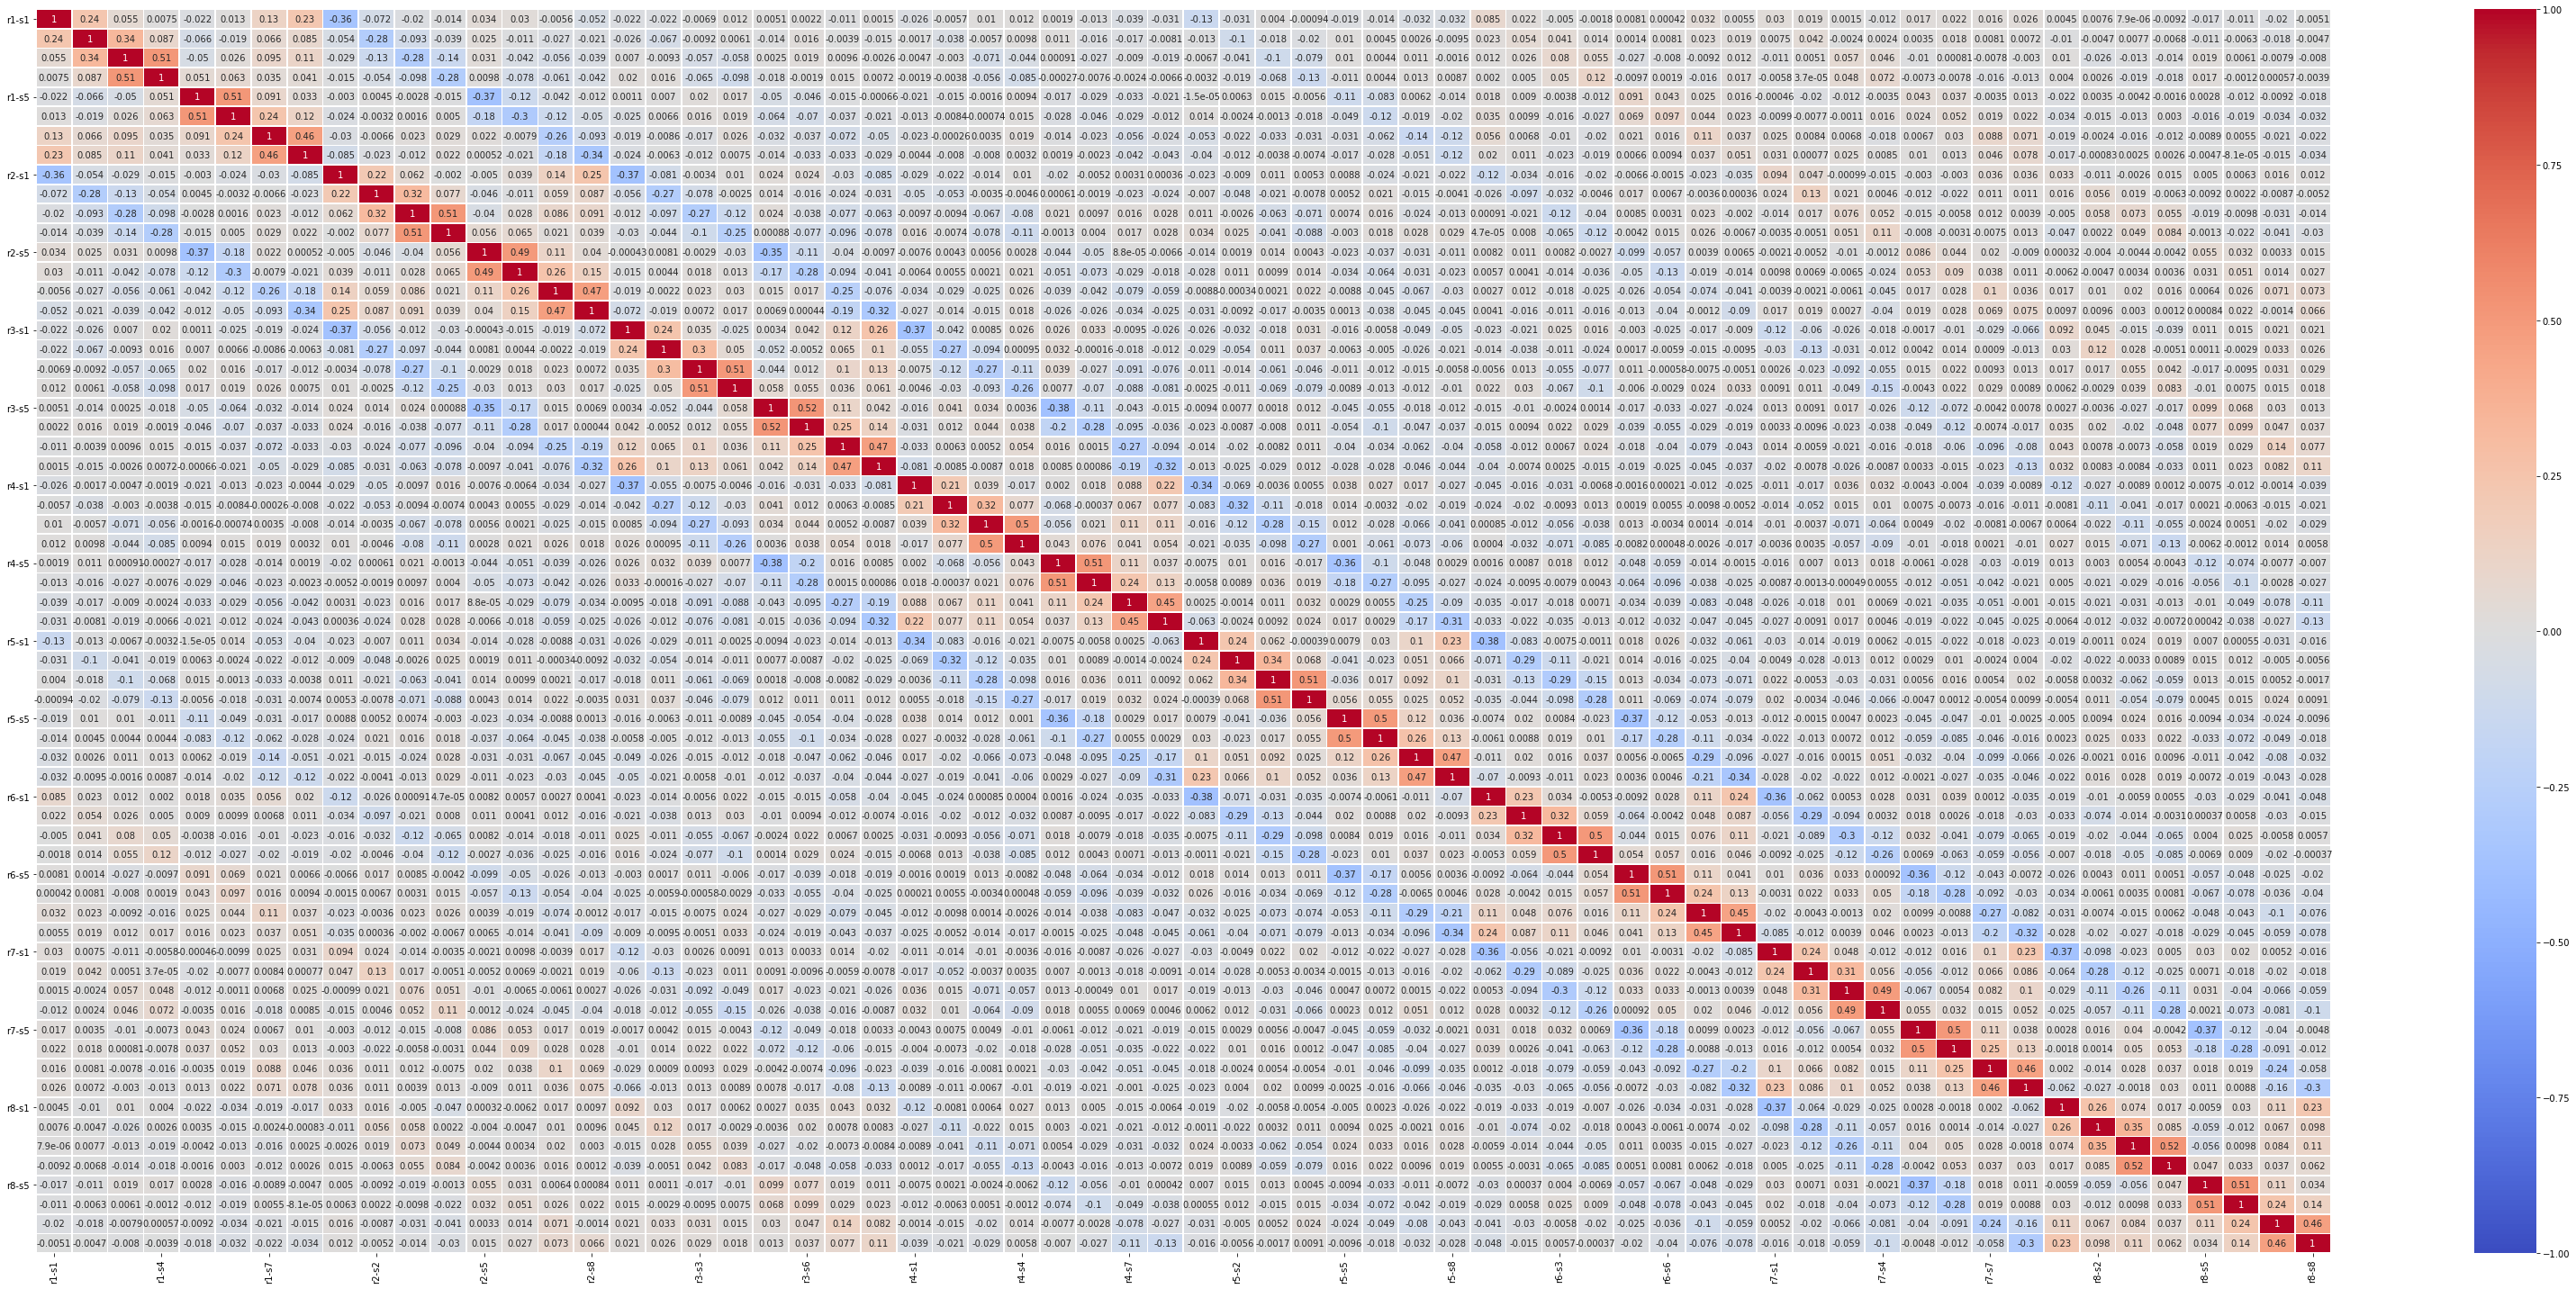

In [7]:
sns.heatmap(data.corr(), annot=True, linewidths= .75, vmin=-1, vmax=1, cmap='coolwarm');
fig = plt.gcf()
fig.set_size_inches(45, 20)
plt.tight_layout();

No observem correlacions massa destacables entre les diferents lectures. En alguns casos hi ha una lleugera correlació entre les lectures consecutives dels sensors i també s'observa una certa correlació entre les lectures dels sensors consecutius, però res que pugui afectar massa la classificació des del nostre punt de vista.

### 3. Preprocessing

Com hem dit a la secció anterior, seria recomanable normalitzar o estandarditzar les dades. Donat que com hem pogut veure totes les columnes tenen distribucions molt semblants optarem per estandarditzar les dades.

In [8]:
standarizer = StandardScaler()
data[data.columns[:-1]] = standarizer.fit_transform(data.iloc[:,:-1])

In [9]:
data.describe()

r1-s1     r1-s2     r1-s3     r1-s4     r1-s5     r1-s6     r1-s7  \
count 11678.000 11678.000 11678.000 11678.000 11678.000 11678.000 11678.000   
mean     -0.000     0.000    -0.000     0.000    -0.000     0.000    -0.000   
std       1.000     1.000     1.000     1.000     1.000     1.000     1.000   
min      -6.220    -8.777    -6.465    -9.981    -6.770    -4.706    -5.051   
25%      -0.457    -0.278    -0.453    -0.439    -0.551    -0.560    -0.188   
50%      -0.026    -0.023    -0.052    -0.036     0.009    -0.017     0.011   
75%       0.405     0.317     0.549     0.501     0.569     0.525     0.210   
max       6.007     7.711     6.962     7.489     5.163     4.942     5.113   

          r1-s8     r2-s1     r2-s2  ...     r7-s7     r7-s8     r8-s1  \
count 11678.000 11678.000 11678.000  ... 11678.000 11678.000 11678.000   
mean      0.000    -0.000     0.000  ...    -0.000    -0.000     0.000   
std       1.000     1.000     1.000  ...     1.000     1.000     1.000   
min      -8.264    -6.033   -10.755  ...    -4.997    -8.383    -6.326   
25%      -0.476    -0.460    -0.283  ...    -0.173    -0.466    -0.448   
50%      -0.022    -0.018    -0.029  ...     0.025    -0.004    -0.009   
75%       0.432     0.368     0.309  ...     0.183     0.457     0.376   
max       8.220     7.044     9.007  ...     5.086     7.582     7.023   

          r8-s2     r8-s3     r8-s4     r8-s5     r8-s6     r8-s7     r8-s8  
count 11678.000 11678.000 11678.000 11678.000 11678.000 11678.000 11678.000  
mean     -0.000     0.000    -0.000    -0.000     0.000    -0.000     0.000  
std       1.000     1.000     1.000     1.000     1.000     1.000     1.000  
min     -10.601    -9.102    -9.926    -5.765    -4.995    -5.010    -7.946  
25%      -0.272    -0.449    -0.446    -0.552    -0.533    -0.180    -0.476  
50%      -0.022    -0.047    -0.040     0.008    -0.024     0.018    -0.025  
75%       0.312     0.557     0.502     0.569     0.523     0.176     0.426  
max       8.808     5.990     7.002     6.174     4.985     5.085     8.217  

[8 rows x 64 columns]

Com hem vist abans, no hi ha 'missing-values', per tant no cal tractar-los. Respecte a les dades categòriques només tenim la columna 'gesture' que és, de fet, el que volem predir, per tant, tampoc hem de tractar-ho. El que sí que tenim és una quantitat raonablement gran de 64 atributs d'entrada que potser podríem intentar reduir. Tanmateix, hem pogut comprovar anteriorment que no hi ha correlacions massa fortes per tant no obtindríem millores considerables per aplicar un PCA.

### 4. Selecció de model

En aquesta secció provarem el rendiment de diferents models i hiperparàmetres per a cada model amb la intenció d'escollir un com el que considerem el millor per posteriorment fer 'cross-validation'.
Entrenarem i avaluarem els següents models:  
- Regressió logística: És potser el classificador més bàsic. Encara que normalment s'utilitza per classificació binària, però entrenant una corba per a cada classe fent un "one vs all" podem obtenir un classificador multicategoría. No esperem obtenir massa bons resultats amb aquest model, però ens servirà per poder comparar.
- SVM: Les SVM són conegudes per tenir un molt bon rendiment en classificació. Sobretot quan la dimensionalitat és alta acostumen a tenir una millor generalització que la resta de models. A més podem provar amb diferents kernels que faran variar els resultats. Els kernels que probarem són:  
    - Lineal
    - Polinomial
    - Base radial
- Random forest: Els "random forests", com sabem, són un ensemble sobre els "decision trees". Gràcies a l'algoritme C4.5 podem utilitzar "decision trees" per fer classificacions que comprenguin valors continus com en el nostre cas. A més gràcies als "random forest" que utilitzen "bagging" podem obtenir un model molt bo format per models senzills, obtenint un bon rendiment a un baix cost computacional. Creiem que poden donar molt bons resultats si resulta que uns els diferents gestos acostumen a tenir sempre unes lectures semblants (que seria lògic).
- KNN: Provarem també amb l'algorisme de KNN, que és molt bàsic, però pot arribar a donar bons resultats en aquest dataset si es compleix que cada gest acostuma a tenir unes seqüències de lectures ben definides i diferenciades entre cada un dels gestos.

En aquest primer experiment, no tunejarem els hiperparàmetres dels models, ja que disposem de molts models i serien massa paràmetres per tunejar. En canvi, avaluarem els models tal com els fa disponibles per defecte sklearn amb la finalitat de trobar 1 o 2 prometedors que estudiarem amb profunditat al cross-validation a la següent secció.

#### Entrenament dels models:

In [10]:
train_x, test_x, train_y, test_y = train_test_split(data.iloc[:,:-1], data.iloc[:,-1], test_size=0.33, random_state=42)

models = ['RegLog', 'SVMLin', 'SVMPol', 'SVMRad', 'RandFor', 'KNN']
metrics = ['Accuracy', 'AvgPrecision', 'AvgRecall', 'TrainingTime']
results = np.zeros((len(models), len(metrics)))

Fem una partició del 33% per a test i la resta per a train. Com hem utilitzat la funció "train_test_split" de sklearn, ens assegurem que les dades estan barrejades adequadament i, per tant, tot seguirà balancejat com havíem vist al principi. De totes maneres farem uns plots senzills per assegurar-nos que és així.
Per una altra banda preparem un array de numpy on desarem els resultats dels models que entrenarem a continuació per poder comparar-los al final i decidir amb quins ens quedem.

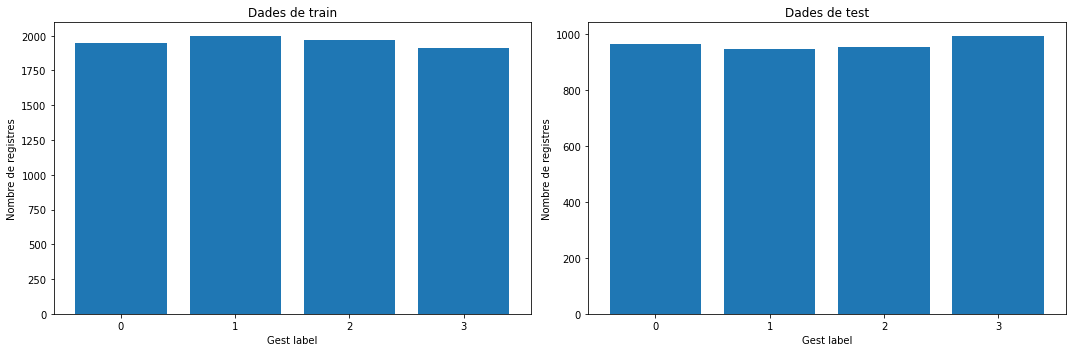

In [11]:
fig, (ax1, ax2) = plt.subplots(1,2)
for ax in [ax1, ax2]:
  if ax == ax1:
    ax.bar(train_y.unique(), train_y.value_counts());
    ax.set_title("Dades de train")
  else:
    ax.bar(test_y.unique(), test_y.value_counts());
    ax.set_title("Dades de test")
  ax.set_xticks([0,1,2,3])
  ax.set_xlabel("Gest label")
  ax.set_ylabel("Nombre de registres")
fig.set_size_inches(15, 5)
plt.tight_layout();

Efectivament tant les dades de test com les de train estan balancejades.

- Regressió Logística:

In [12]:
t = time.time()
lr = LogisticRegression().fit(train_x, train_y.astype('int'))
predictions = lr.predict(test_x)
print(classification_report(test_y.astype('int'), predictions.astype('int')))
report = classification_report(test_y.astype('int'), predictions.astype('int'), output_dict=True)
res = np.array([report['accuracy'], report['macro avg']['precision'], report['macro avg']['recall'], time.time() - t])
results[0] = res

              precision    recall  f1-score   support

           0       0.50      0.47      0.48       963
           1       0.35      0.28      0.31       991
           2       0.27      0.30      0.28       947
           3       0.30      0.35      0.32       953

    accuracy                           0.35      3854
   macro avg       0.35      0.35      0.35      3854
weighted avg       0.35      0.35      0.35      3854



- SVM Lineal:

In [13]:
t = time.time()
SVMLin = SVC(kernel="linear").fit(train_x, train_y.astype('int'))
predictions = SVMLin.predict(test_x)
print(classification_report(test_y.astype('int'), predictions.astype('int')))
report = classification_report(test_y.astype('int'), predictions.astype('int'), output_dict=True)
res = np.array([report['accuracy'], report['macro avg']['precision'], report['macro avg']['recall'], time.time() - t])
results[1] = res

              precision    recall  f1-score   support

           0       0.91      0.30      0.45       963
           1       0.32      0.39      0.35       991
           2       0.27      0.35      0.31       947
           3       0.30      0.36      0.32       953

    accuracy                           0.35      3854
   macro avg       0.45      0.35      0.36      3854
weighted avg       0.45      0.35      0.36      3854



- SVM Polinimial:

In [14]:
t = time.time()
SVMPol = SVC(kernel="poly").fit(train_x, train_y.astype('int'))
predictions = SVMPol.predict(test_x)
print(classification_report(test_y.astype('int'), predictions.astype('int')))
report = classification_report(test_y.astype('int'), predictions.astype('int'), output_dict=True)
res = np.array([report['accuracy'], report['macro avg']['precision'], report['macro avg']['recall'], time.time() - t])
results[2] = res

              precision    recall  f1-score   support

           0       0.92      0.34      0.50       963
           1       0.48      0.53      0.50       991
           2       0.75      0.18      0.29       947
           3       0.33      0.76      0.46       953

    accuracy                           0.45      3854
   macro avg       0.62      0.45      0.44      3854
weighted avg       0.62      0.45      0.44      3854



- SVM amb base radial:

In [15]:
t = time.time()
SVMRad = SVC(kernel="rbf").fit(train_x, train_y.astype('int'))
predictions = SVMRad.predict(test_x)
print(classification_report(test_y.astype('int'), predictions.astype('int')))
report = classification_report(test_y.astype('int'), predictions.astype('int'), output_dict=True)
res = np.array([report['accuracy'], report['macro avg']['precision'], report['macro avg']['recall'], time.time() - t])
results[3] = res

              precision    recall  f1-score   support

           0       0.92      0.91      0.91       963
           1       0.87      0.98      0.92       991
           2       0.93      0.84      0.88       947
           3       0.85      0.84      0.84       953

    accuracy                           0.89      3854
   macro avg       0.89      0.89      0.89      3854
weighted avg       0.89      0.89      0.89      3854



- Random Forest:

In [16]:
t = time.time()
rf = RandomForestClassifier().fit(train_x, train_y.astype('int'))
predictions = rf.predict(test_x)
print(classification_report(test_y.astype('int'), predictions.astype('int')))
report = classification_report(test_y.astype('int'), predictions.astype('int'), output_dict=True)
res = np.array([report['accuracy'], report['macro avg']['precision'], report['macro avg']['recall'], time.time() - t])
results[4] = res

              precision    recall  f1-score   support

           0       0.92      0.97      0.94       963
           1       0.95      0.90      0.92       991
           2       0.90      0.94      0.92       947
           3       0.87      0.84      0.86       953

    accuracy                           0.91      3854
   macro avg       0.91      0.91      0.91      3854
weighted avg       0.91      0.91      0.91      3854



- KNN:

In [17]:
t = time.time()
knn = KNeighborsClassifier().fit(train_x, train_y.astype('int'))
predictions = knn.predict(test_x)
print(classification_report(test_y.astype('int'), predictions.astype('int')))
report = classification_report(test_y.astype('int'), predictions.astype('int'), output_dict=True)
res = np.array([report['accuracy'], report['macro avg']['precision'], report['macro avg']['recall'], time.time() - t])
results[5] = res

              precision    recall  f1-score   support

           0       0.94      0.65      0.77       963
           1       0.57      0.92      0.70       991
           2       0.83      0.32      0.46       947
           3       0.59      0.76      0.67       953

    accuracy                           0.67      3854
   macro avg       0.73      0.66      0.65      3854
weighted avg       0.73      0.67      0.65      3854



Una vegada entrenats i testejats tots els models sense tunejar, observem i comparem de manera gràfica els seus resultats per a escollir aquells més prometedors sobre els que farem "fine tuning" per intentar obtenir els millors resulats prossibles i sobre els que farem "cross-validation" per assegurar-nos de que els resultats obtinguts no han sigut obtinguts per a sort d'ahver escollit unes dades d'entrenament i test determinades.

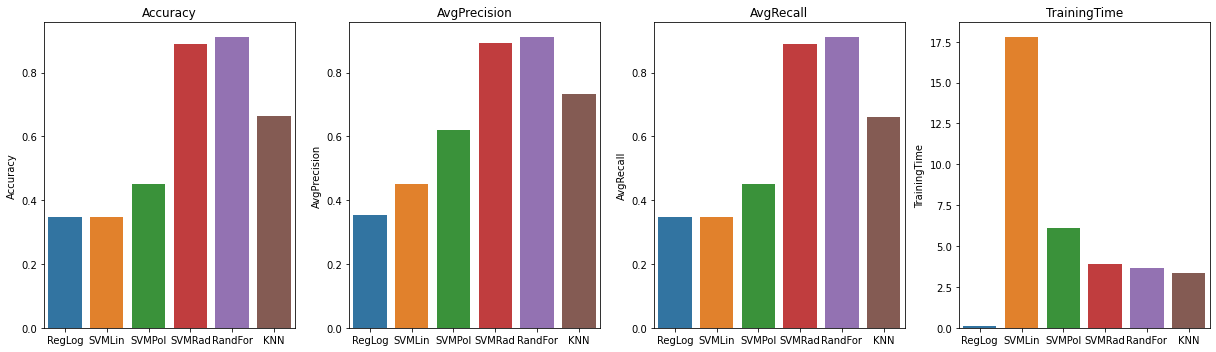

In [18]:
results_df = pd.DataFrame(data = results, columns = metrics, index = models)
fig = plt.figure()
for i in range(1,5):
  ax = fig.add_subplot(1,4,i)
  ax.set_title(metrics[i-1])
  sns.barplot(ax = ax, data=results_df, x=models, y=metrics[i-1]);
fig.set_size_inches(17, 5)
plt.tight_layout();


In [19]:
results_df

Accuracy  AvgPrecision  AvgRecall  TrainingTime
RegLog      0.347         0.353      0.347         0.127
SVMLin      0.349         0.452      0.348        17.794
SVMPol      0.452         0.622      0.451         6.123
SVMRad      0.891         0.892      0.890         3.910
RandFor     0.912         0.912      0.912         3.634
KNN         0.666         0.733      0.663         3.331

Podem observar com tant el model de regressió logística, la màquina de vectors de suport amb kernel lineal i la que utilitza kernel polinomial no han sigut capaços d'adaptarse a les dades. A més, les dues màquines de vectors de suports ara mencionades són els models que més triguen en executar el seu entrenament. No passa el mateix amb la regressió logística, que es el model que requereix menys temps per ser entrenat, però evidentment no val la pena utilitzar aquest model degut als seus resultats.  
En cuant al KNN, no ha donat massa bons resultats, però sí que es desmarca considerablement respecte als dos models anteriors. Probablement si fessim un "fine tuning" d'aquest model podríem aconseguir millors resultats, però preferim centrar-nos en els dos models més prometedors.  
Per una altra banda, tenim els models de la màquina de vector de suport amb kernel radial i el random forest. Aquests han sigut els models que han aconseguit les 2 millors puntuacions tant en "accuracy" com en la mitja de "precision" i "recall". Per tant són els que escollirem per a assegurar-nos del seu rendiment amb el "cross-validation" i sobre els que farem "fine tuning" per intentar aconseguir els millors resultats possibles.

### 5. Crossvalidation

En aquesta secció, com hem dit, ens assegurarem de que els resultats que hem obtingut anteriorment amb els models de random forest i la màquina de vectors de suport amb kernel radial no han sigut sort. això es pot donar quant per coincidencia, es seleccionen de manera aleatoria unes particions de test i train que són "benficioses" per al rendiment dels models en quan s'entrenen i s'avaluen amb les respectives particions.  
Per assegurar-nos de que no ha sigut sort, podem optar per fer "cross-validation". Hi ha diferents mètodes de avaluació creuada però nosaltres optarem per k-fold i anirem modificant el valor de la k, és a dir, el número de particions del dataset, escollim Kfold perquè ens permet que fagi un shuffel però evita que fem test sobre dades que ja estaven en test en altres splits i leave one out seria massa costos computacionalment.

In [20]:
X = data.iloc[:,:-1]
X = X.values
y = data.iloc[:,-1]
y = y.values

models_nfolds = ['SVM5', 'SVM10', 'SVM15', 'RandF5', 'RandF10', 'RandF15']
metrics = ['Accuracy', 'AvgPrecision', 'AvgRecall']
results = np.zeros((len(models_nfolds), len(metrics)))

#### SVM amb base radial:

- 5-Fold

In [21]:
n=5
kf = KFold(n_splits=n,shuffle=True)

total_acc = 0
total_pre = 0
total_rec = 0

for train_index, test_index in kf.split(X):
    train_x, test_x = X[train_index], X[test_index]
    train_y, test_y = y[train_index], y[test_index]
    
    SVMRad = SVC(kernel="rbf").fit(train_x, train_y.astype('int'))
    predictions = SVMRad.predict(test_x)
    report = classification_report(test_y.astype('int'), predictions.astype('int'), output_dict=True)
    res = np.array([report['accuracy'], report['macro avg']['precision'], report['macro avg']['recall']])
    total_acc +=report['accuracy']
    total_pre += report['macro avg']['precision']
    total_rec += report['macro avg']['recall']
res=np.array([total_acc / n, total_pre / n, total_rec / n])
print(f"Accuracy:{res[0]} Precision: {res[1]} Recall: {res[2]}")
results[0]=res

Accuracy:0.898613380364319 Precision: 0.9001096267545332 Recall: 0.8988117383376293


- 10-Fold

In [22]:
n=10
kf = KFold(n_splits=n,shuffle=True)

total_acc = 0
total_pre = 0
total_rec = 0

for train_index, test_index in kf.split(X):
    train_x, test_x = X[train_index], X[test_index]
    train_y, test_y = y[train_index], y[test_index]
    
    SVMRad = SVC(kernel="rbf").fit(train_x, train_y.astype('int'))
    predictions = SVMRad.predict(test_x)
    report = classification_report(test_y.astype('int'), predictions.astype('int'), output_dict=True)
    res = np.array([report['accuracy'], report['macro avg']['precision'], report['macro avg']['recall']])
    total_acc +=report['accuracy']
    total_pre += report['macro avg']['precision']
    total_rec += report['macro avg']['recall']
res=np.array([total_acc / n, total_pre / n, total_rec / n])
print(f"Accuracy:{res[0]} Precision: {res[1]} Recall: {res[2]}")
results[1]=res

Accuracy:0.9043496378725454 Precision: 0.9059947078867113 Recall: 0.9044553355138817


- 15-Fold

In [23]:
n=15
kf = KFold(n_splits=n,shuffle=True)

total_acc = 0
total_pre = 0
total_rec = 0

for train_index, test_index in kf.split(X):
    train_x, test_x = X[train_index], X[test_index]
    train_y, test_y = y[train_index], y[test_index]
    
    SVMRad = SVC(kernel="rbf").fit(train_x, train_y.astype('int'))
    predictions = SVMRad.predict(test_x)
    report = classification_report(test_y.astype('int'), predictions.astype('int'), output_dict=True)
    res = np.array([report['accuracy'], report['macro avg']['precision'], report['macro avg']['recall']])
    total_acc +=report['accuracy']
    total_pre += report['macro avg']['precision']
    total_rec += report['macro avg']['recall']
res=np.array([total_acc / n, total_pre / n, total_rec / n])
print(f"Accuracy:{res[0]} Precision: {res[1]} Recall: {res[2]}")
results[2]=res

Accuracy:0.904523739595399 Precision: 0.9058866644786968 Recall: 0.9043583812951321


In [24]:
svm_results_df = pd.DataFrame(results[:3], index=models_nfolds[:3], columns=metrics)
svm_results_df

Accuracy  AvgPrecision  AvgRecall
SVM5      0.899         0.900      0.899
SVM10     0.904         0.906      0.904
SVM15     0.905         0.906      0.904

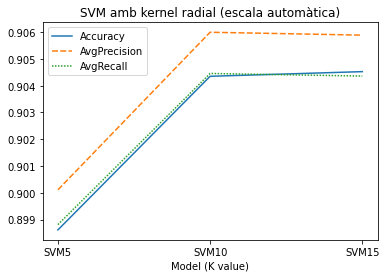

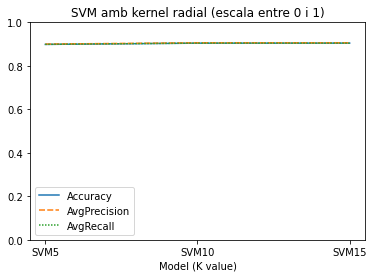

In [25]:
sns.lineplot(data=svm_results_df);
plt.xlabel("Model (K value)");
plt.title("SVM amb kernel radial (escala automàtica)");
plt.show();

sns.lineplot(data=svm_results_df);
plt.ylim(0,1);
plt.xlabel("Model (K value)");
plt.title("SVM amb kernel radial (escala entre 0 i 1)");
plt.show();


Veiem com hi ha petites variacions en els resultats obtinguts amb les diferents particions, però podem concluir que el model es comporta bé i, per tant, els resultats que haviem obtingut anteriorment no eren sort i la màquina de suport de vectors utilitzant un kernel radial és un bon model per al problema que intentem resoldre.

#### Random Forest:

- 5-Fold

In [26]:
n=5
kf = KFold(n_splits=n,shuffle=True)

total_acc = 0
total_pre = 0
total_rec = 0

for train_index, test_index in kf.split(X):
    train_x, test_x = X[train_index], X[test_index]
    train_y, test_y = y[train_index], y[test_index]
    
    rf = RandomForestClassifier().fit(train_x, train_y.astype('int'))
    predictions = rf.predict(test_x)
    report = classification_report(test_y.astype('int'), predictions.astype('int'), output_dict=True)
    res = np.array([report['accuracy'], report['macro avg']['precision'], report['macro avg']['recall']])
    total_acc +=report['accuracy']
    total_pre += report['macro avg']['precision']
    total_rec += report['macro avg']['recall']
res=np.array([total_acc / n, total_pre / n, total_rec / n])
print(f"Accuracy:{res[0]} Precision: {res[1]} Recall: {res[2]}")
results[3]=res

Accuracy:0.9189075562465167 Precision: 0.9190974348865197 Recall: 0.9190270656884806


- 10-Fold

In [27]:
n=10
kf = KFold(n_splits=n,shuffle=True)

total_acc = 0
total_pre = 0
total_rec = 0

for train_index, test_index in kf.split(X):
    train_x, test_x = X[train_index], X[test_index]
    train_y, test_y = y[train_index], y[test_index]
    
    rf = RandomForestClassifier().fit(train_x, train_y.astype('int'))
    predictions = rf.predict(test_x)
    report = classification_report(test_y.astype('int'), predictions.astype('int'), output_dict=True)
    res = np.array([report['accuracy'], report['macro avg']['precision'], report['macro avg']['recall']])
    total_acc +=report['accuracy']
    total_pre += report['macro avg']['precision']
    total_rec += report['macro avg']['recall']
res=np.array([total_acc / n, total_pre / n, total_rec / n])
print(f"Accuracy:{res[0]} Precision: {res[1]} Recall: {res[2]}")
results[4]=res

Accuracy:0.9195921517531195 Precision: 0.9196922003382568 Recall: 0.9196040388052911


- 15-Fold

In [28]:
n=15
kf = KFold(n_splits=n,shuffle=True)

total_acc = 0
total_pre = 0
total_rec = 0

for train_index, test_index in kf.split(X):
    train_x, test_x = X[train_index], X[test_index]
    train_y, test_y = y[train_index], y[test_index]
    
    rf = RandomForestClassifier().fit(train_x, train_y.astype('int'))
    predictions = rf.predict(test_x)
    report = classification_report(test_y.astype('int'), predictions.astype('int'), output_dict=True)
    res = np.array([report['accuracy'], report['macro avg']['precision'], report['macro avg']['recall']])
    total_acc +=report['accuracy']
    total_pre += report['macro avg']['precision']
    total_rec += report['macro avg']['recall']
res=np.array([total_acc / n, total_pre / n, total_rec / n])
print(f"Accuracy:{res[0]} Precision: {res[1]} Recall: {res[2]}")
results[5]=res

Accuracy:0.9194222153289048 Precision: 0.9194419914694119 Recall: 0.9197309729015515


In [29]:
rf_results_df = pd.DataFrame(results[3:], index=models_nfolds[3:], columns=metrics)
rf_results_df

Accuracy  AvgPrecision  AvgRecall
RandF5      0.919         0.919      0.919
RandF10     0.920         0.920      0.920
RandF15     0.919         0.919      0.920

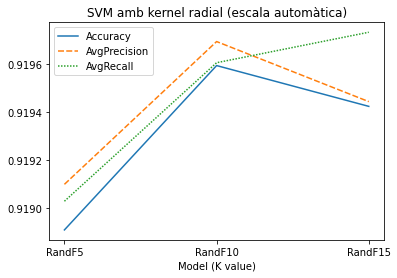

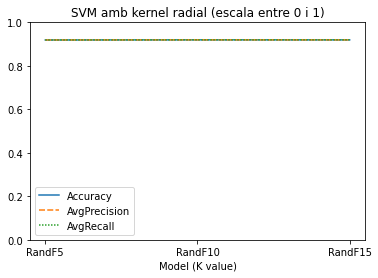

In [30]:
sns.lineplot(data=rf_results_df);
plt.xlabel("Model (K value)");
plt.title("SVM amb kernel radial (escala automàtica)");
plt.show();

sns.lineplot(data=rf_results_df);
plt.ylim(0,1);
plt.xlabel("Model (K value)");
plt.title("SVM amb kernel radial (escala entre 0 i 1)");
plt.show();

Per al random forest concluim el matéix que per a la SVM amb kernel radial.

In [31]:
results_df

Accuracy  AvgPrecision  AvgRecall  TrainingTime
RegLog      0.347         0.353      0.347         0.127
SVMLin      0.349         0.452      0.348        17.794
SVMPol      0.452         0.622      0.451         6.123
SVMRad      0.891         0.892      0.890         3.910
RandFor     0.912         0.912      0.912         3.634
KNN         0.666         0.733      0.663         3.331

Sobre el dos models seleccionats en l'apartat anterior fem diferents "cross-validation" cambiant la K. Com podem veure en els resultats, quant més gran és K millors resultats obtenim però més triga en obtenirlos per tant no seria bona idea implementar el "leave one out" en aquest cas. També podem observar millors resultats amb el Random Forest com ja venia sent el cas en l'apartat anterior. Però podem dir amb seguretat que ambdos models tenen un bon rendiment sobre le sdades i que les aconsegueixen generalitzar de manera bastant satisfactoria.  
Ara passarem a buscar els millors hiperparàmetres per als models amb la finalitat d'intentar conseguir els millors resultats possibles.

### 6. Metric Analysis

### 7. Hyperparameters Search

En aquest apartat tenim la intenció de determinar quins són els hiperparàmetres que fan que els nostres dos models seleccionats (random forest i svm amb kernel radial) tinguin el millor rendiment possible quan s'apliquen a les dades amb les que treballem.
Per tant, és important decidir quins seràn aquests hiperparàmetres de cada un dels models dels quals buscarem els seus valors òptims.  

Per a Random Forest:
- n_estimators: Aquest paràmetre ens determina el número d'arbres de decisió que compossen el nostre random forest. En teoría, a més árbres millors resultats hauríem de podet obtenir, però arriva un moment on la millora es negligible, inexistent o inclús el model empitjora en comptes de millorar degut a l'overfitting.
- max_depth: Aquest paràmetre determina la profunditat (número de nodes del camí més llarg) màxima dels arbres de decisió que formen el random forest.  

Per a SVM amb kernel radial:
- C
- Gamma

#### Busqueda d'hiperparàmetres per al Random Forest

- Random Search amb Cross Validation

In [53]:
model_params = {
    'n_estimators': np.random.randint(20,201,size=(100)),
    'max_depth': np.random.randint(1,16,size=(100))
}
rf = RandomForestClassifier()
clf = RandomizedSearchCV(rf, model_params, n_iter=100, cv=5, random_state=42, n_jobs=-1, verbose=1)

In [54]:
X = data[data.columns[:-1]]
y = data[data.columns[-1]].astype('int')
best_rf = clf.fit(X,y)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   35.6s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.8min finished


In [55]:
print(f'Hiperparàmetres òptims trobats per RandomizedSearchCV: n_estimators: {best_rf.best_estimator_.get_params()["n_estimators"]}, max_depth: {best_rf.best_estimator_.get_params()["max_depth"]}')

Hiperparàmetres òptims trobats per RandomizedSearchCV: n_estimators: 185, max_depth: 15


In [57]:
kf = KFold(n_splits=5,shuffle=True)

total_acc = 0
total_pre = 0
total_rec = 0

for train_index, test_index in kf.split(X):
    train_x, test_x = X.values[train_index], X.values[test_index]
    train_y, test_y = y.values[train_index], y.values[test_index]
    
    rf = RandomForestClassifier(
        n_estimators=best_rf.best_estimator_.get_params()["n_estimators"],
        max_depth=best_rf.best_estimator_.get_params()["max_depth"]
    ).fit(train_x, train_y.astype('int'))
    predictions = rf.predict(test_x)
    report = classification_report(test_y.astype('int'), predictions.astype('int'), output_dict=True)
    res = np.array([report['accuracy'], report['macro avg']['precision'], report['macro avg']['recall']])
    total_acc +=report['accuracy']
    total_pre += report['macro avg']['precision']
    total_rec += report['macro avg']['recall']

In [59]:
print(f'Accuracy = {total_acc/5}, Precision: {total_pre/5}, Recall: {total_rec/5}')

Accuracy = 0.9145411545569212, Precision: 0.9140401502624668, Recall: 0.9145399676180764


- Grid Search amb Cross Validation

In [60]:
n_estimators = [25, 50, 75, 100, 125, 150, 175, 200]
max_depth = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

In [61]:
X = data[data.columns[:-1]]
y = data[data.columns[-1]].astype('int') 
rf = RandomForestClassifier()
clf = dict(n_estimators = n_estimators, max_depth = max_depth)

gridF = GridSearchCV(rf, clf, cv = 5, verbose = 1, n_jobs = -1) 
best_rf = gridF.fit(X, y)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 212 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done 462 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  2.1min finished


In [62]:
print(f'Hiperparàmetres òptims trobats per GridSearchCV: n_estimators: {bestF.best_estimator_.get_params()["n_estimators"]}, max_depth: {bestF.best_estimator_.get_params()["max_depth"]}')

Hiperparàmetres òptims trobats per GridSearchCV: n_estimators: 150, max_depth: 15


In [63]:
kf = KFold(n_splits=5,shuffle=True)

total_acc = 0
total_pre = 0
total_rec = 0

for train_index, test_index in kf.split(X):
    train_x, test_x = X.values[train_index], X.values[test_index]
    train_y, test_y = y.values[train_index], y.values[test_index]
    
    rf = RandomForestClassifier(
        n_estimators=best_rf.best_estimator_.get_params()["n_estimators"],
        max_depth=best_rf.best_estimator_.get_params()["max_depth"]
    ).fit(train_x, train_y.astype('int'))
    predictions = rf.predict(test_x)
    report = classification_report(test_y.astype('int'), predictions.astype('int'), output_dict=True)
    res = np.array([report['accuracy'], report['macro avg']['precision'], report['macro avg']['recall']])
    total_acc +=report['accuracy']
    total_pre += report['macro avg']['precision']
    total_rec += report['macro avg']['recall']

In [64]:
print(f'Accuracy = {total_acc/5}, Precision: {total_pre/5}, Recall: {total_rec/5}')

Accuracy = 0.9145399078935789, Precision: 0.9140550694082179, Recall: 0.9146759860808432


#### Busqueda d'hiperparàmetres per a la SVM amb kernel radial

- Random Search amb Cross Validation

In [69]:
model_params = {
    'C': uniform(2, 10),
    'gamma': uniform(0.1, 1)
}
svm = SVC(kernel='rbf')
clf = RandomizedSearchCV(svm, model_params, n_iter=100, cv=5, random_state=42, n_jobs=-1, verbose=1)

In [70]:
X = data[data.columns[:-1]]
y = data[data.columns[-1]].astype('int')
best_svm = clf.fit(X,y)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed: 19.6min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 22.8min finished


In [72]:
print(f'Hiperparàmetres òptims trobats per RandomizedSearchCV: C: {best_svm.best_estimator_.get_params()["C"]}, gamma: {best_svm.best_estimator_.get_params()["gamma"]}')

Hiperparàmetres òptims trobats per RandomizedSearchCV: C: 8.775643618422825, gamma: 0.11658782892785616


In [73]:
kf = KFold(n_splits=5,shuffle=True)

total_acc = 0
total_pre = 0
total_rec = 0

for train_index, test_index in kf.split(X):
    train_x, test_x = X.values[train_index], X.values[test_index]
    train_y, test_y = y.values[train_index], y.values[test_index]
    
    svm = SVC(kernel='rbf',
             C=best_svm.best_estimator_.get_params()["C"],
            gamma=best_svm.best_estimator_.get_params()["gamma"]
             ).fit(train_x, train_y.astype('int'))
    predictions = rf.predict(test_x)
    report = classification_report(test_y.astype('int'), predictions.astype('int'), output_dict=True)
    res = np.array([report['accuracy'], report['macro avg']['precision'], report['macro avg']['recall']])
    total_acc +=report['accuracy']
    total_pre += report['macro avg']['precision']
    total_rec += report['macro avg']['recall']

In [74]:
print(f'Accuracy = {total_acc/5}, Precision: {total_pre/5}, Recall: {total_rec/5}')

Accuracy = 0.9562428500190666, Precision: 0.9564258542292116, Recall: 0.9561003911003484


In [75]:
model_params = {
    "C": np.arange(2, 10, 2),
    "gamma": np.arange(0.1, 1, 0.2)
}

In [76]:
X = data[data.columns[:-1]]
y = data[data.columns[-1]].astype('int') 
svm = SVC(kernel='rbf')

gridF = GridSearchCV(svm, model_params, cv = 5, verbose = 1, n_jobs = -1) 
best_svm = gridF.fit(X, y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.5min finished


In [77]:
print(f'Hiperparàmetres òptims trobats per GridSearchCV: C: {best_svm.best_estimator_.get_params()["C"]}, gamma: {best_svm.best_estimator_.get_params()["gamma"]}')

Hiperparàmetres òptims trobats per GridSearchCV: C: 6, gamma: 0.1


In [78]:
kf = KFold(n_splits=5,shuffle=True)

total_acc = 0
total_pre = 0
total_rec = 0

for train_index, test_index in kf.split(X):
    train_x, test_x = X.values[train_index], X.values[test_index]
    train_y, test_y = y.values[train_index], y.values[test_index]
    
    svm = SVC(kernel='rbf',
             C=best_svm.best_estimator_.get_params()["C"],
            gamma=best_svm.best_estimator_.get_params()["gamma"]
             ).fit(train_x, train_y.astype('int'))
    predictions = rf.predict(test_x)
    report = classification_report(test_y.astype('int'), predictions.astype('int'), output_dict=True)
    res = np.array([report['accuracy'], report['macro avg']['precision'], report['macro avg']['recall']])
    total_acc +=report['accuracy']
    total_pre += report['macro avg']['precision']
    total_rec += report['macro avg']['recall']

In [79]:
print(f'Accuracy = {total_acc/5}, Precision: {total_pre/5}, Recall: {total_rec/5}')

Accuracy = 0.9562427766859288, Precision: 0.9565439383288158, Recall: 0.9562360927979198


Primer de tot veiem com tant en el Random Forest i la Màquina de vectors obtenen hiperparàmetres diferents segons segons si utilitzen el Random Search o el Grid Search però tots dos metodes obtenen un resultat molt similar on la diferència pot ser negligible.                      
Ara bé, a l'hora de comparar els resultats entre Random Forest i la Màquina de vectors, hem de dir que, encara que la màquina ha obtingut millors resultats, el temps per obtenir-lo ha sigut més de 10 vegades el temps que ha trigat el Random Forest per tant si és tingues un temps molt limitat seria la millor opció.

## Apartat A: Classificació Avançada

### 1. Import i preprocessat de les dades

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import time
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [3]:
#Per tal de tractar amb arxius d'audio utilitzarem la llibreria Librosa
import librosa
import librosa.display
import IPython.display as ipd
import warnings
warnings.filterwarnings('ignore')

import os

In [4]:
DF3 = pd.read_csv('./data/features_3_sec.csv',delimiter=',')
DF30 = pd.read_csv('./data/features_30_sec.csv',delimiter=',')

En aquest problema existeixen 2 datasets. El "base" seria l'anomenat "DF30". Aquest Dataset té totes les dades recollides fent una mitjana de 30 segons de cada fragment d'audio.
El Dataset DF3 té aquests 30 segons repartits per 10 instancies diferents, on a cada instancia hi ha la mitja de fragments de 3 segons.
Per tant, si el primer dataset té 1000 files (instancies), el segon dataset en té (9990)

### 2. Explanatory Data Analysis

In [4]:
DF3.describe()

length  chroma_stft_mean  chroma_stft_var  rms_mean  rms_var  \
count  9990.000          9990.000         9990.000  9990.000 9990.000   
mean  66149.000             0.380            0.085     0.131    0.003   
std       0.000             0.090            0.010     0.069    0.004   
min   66149.000             0.107            0.015     0.001    0.000   
25%   66149.000             0.316            0.080     0.084    0.001   
50%   66149.000             0.385            0.085     0.121    0.001   
75%   66149.000             0.442            0.091     0.176    0.003   
max   66149.000             0.749            0.121     0.443    0.033   

       spectral_centroid_mean  spectral_centroid_var  spectral_bandwidth_mean  \
count                9990.000               9990.000                 9990.000   
mean                 2199.219             416672.699                 2241.386   
std                   751.861             434964.436                  543.854   
min                   472.742                811.881                  499.163   
25%                  1630.680             123196.131                 1887.456   
50%                  2208.628             265069.215                 2230.576   
75%                  2712.582             562415.249                 2588.341   
max                  5432.534            4794118.600                 3708.148   

       spectral_bandwidth_var  rolloff_mean  ...  mfcc16_mean  mfcc16_var  \
count                9990.000      9990.000  ...     9990.000    9990.000   
mean               118271.113      4566.077  ...        1.448      49.989   
std                101350.463      1642.065  ...        5.735      34.443   
min                  1183.520       658.336  ...      -26.850       1.326   
25%                 48765.527      3378.311  ...       -2.227      29.585   
50%                 89960.720      4631.378  ...        1.462      41.702   
75%                158567.353      5591.635  ...        5.150      59.275   
max               1235142.513      9487.446  ...       39.144     683.933   

       mfcc17_mean  mfcc17_var  mfcc18_mean  mfcc18_var  mfcc19_mean  \
count     9990.000    9990.000     9990.000    9990.000     9990.000   
mean        -4.199      51.963        0.740      52.489       -2.497   
std          5.677      36.401        5.181      38.177        5.112   
min        -27.810       1.625      -20.734       3.437      -27.448   
25%         -7.952      29.863       -2.517      29.636       -5.734   
50%         -4.443      42.394        0.734      41.831       -2.702   
75%         -0.727      61.677        3.889      62.034        0.514   
max         34.049     529.363       36.970     629.730       31.365   

       mfcc19_var  mfcc20_mean  mfcc20_var  
count    9990.000     9990.000    9990.000  
mean       54.974       -0.918      57.323  
std        41.586        5.253      46.444  
min         3.065      -35.641       0.282  
25%        30.496       -4.004      30.011  
50%        43.435       -1.031      44.332  
75%        65.329        2.217      68.210  
max      1143.231       34.212     910.473  

[8 rows x 58 columns]

Podem veure com al dataset dels fragments de 3 segons tenim tots els atributs en forma d'enters, menys la primera columna que ens indica el nom de l'arxiu d'audio al qual pertany la instancia i l'últim que conté la etiqueta que indica el gènere real del fragment. Aquest serà el nostre valor objectiu.

In [5]:
nullValues = 0
for n in DF30.isna().sum():
    if n != 0: nullValues += 1
print(f'Nombre de "missing-values" a DF30: {nullValues}')

nullValues = 0
for n in DF3.isna().sum():
    if n != 0: nullValues += 1
print(f'Nombre de "missing-values" a DF3: {nullValues}')

Nombre de "missing-values" a DF30: 0
Nombre de "missing-values" a DF3: 0


Tenim un total de 0 missing-values en tots dos datasets. Aquest fet ens ajudarà en la tasca de creació de models i estandarditzar les dades.

In [6]:
print(DF30.columns)

Index(['filename', 'length', 'chroma_stft_mean', 'chroma_stft_var', 'rms_mean',
       'rms_var', 'spectral_centroid_mean', 'spectral_centroid_var',
       'spectral_bandwidth_mean', 'spectral_bandwidth_var', 'rolloff_mean',
       'rolloff_var', 'zero_crossing_rate_mean', 'zero_crossing_rate_var',
       'harmony_mean', 'harmony_var', 'perceptr_mean', 'perceptr_var', 'tempo',
       'mfcc1_mean', 'mfcc1_var', 'mfcc2_mean', 'mfcc2_var', 'mfcc3_mean',
       'mfcc3_var', 'mfcc4_mean', 'mfcc4_var', 'mfcc5_mean', 'mfcc5_var',
       'mfcc6_mean', 'mfcc6_var', 'mfcc7_mean', 'mfcc7_var', 'mfcc8_mean',
       'mfcc8_var', 'mfcc9_mean', 'mfcc9_var', 'mfcc10_mean', 'mfcc10_var',
       'mfcc11_mean', 'mfcc11_var', 'mfcc12_mean', 'mfcc12_var', 'mfcc13_mean',
       'mfcc13_var', 'mfcc14_mean', 'mfcc14_var', 'mfcc15_mean', 'mfcc15_var',
       'mfcc16_mean', 'mfcc16_var', 'mfcc17_mean', 'mfcc17_var', 'mfcc18_mean',
       'mfcc18_var', 'mfcc19_mean', 'mfcc19_var', 'mfcc20_mean', 'mfcc20_var',
  

Aquests són les etiquetes dels atributs que té la nostre base de dades. L'atribut label és el nostre valor objectiu, que serà el que després intentarem predir. Aquest pot tenir aquests valors:

+ Blues
+ Classical
+ Country
+ Disco
+ HipHop
+ Jazz
+ Metal
+ Pop
+ Reggae
+ Rock

In [7]:
DF3.head()

filename  length  chroma_stft_mean  chroma_stft_var  rms_mean  \
0  blues.00000.0.wav   66149             0.335            0.091     0.130   
1  blues.00000.1.wav   66149             0.343            0.086     0.113   
2  blues.00000.2.wav   66149             0.347            0.092     0.132   
3  blues.00000.3.wav   66149             0.364            0.087     0.133   
4  blues.00000.4.wav   66149             0.336            0.088     0.143   

   rms_var  spectral_centroid_mean  spectral_centroid_var  \
0    0.004                1773.065             167541.631   
1    0.001                1816.694              90525.691   
2    0.005                1788.540             111407.438   
3    0.002                1655.289             111952.285   
4    0.002                1630.656              79667.268   

   spectral_bandwidth_mean  spectral_bandwidth_var  ...  mfcc16_var  \
0                 1972.744              117335.772  ...      39.687   
1                 2010.052               65671.876  ...      64.748   
2                 2084.565               75124.922  ...      67.337   
3                 1960.040               82913.639  ...      47.739   
4                 1948.504               60204.020  ...      30.336   

   mfcc17_mean  mfcc17_var  mfcc18_mean  mfcc18_var  mfcc19_mean  mfcc19_var  \
0       -3.241      36.488        0.722      38.099       -5.050      33.618   
1       -6.055      40.678        0.159      51.264       -2.838      97.031   
2       -1.769      28.349        2.379      45.718       -1.938      53.051   
3       -3.841      28.337        1.219      34.771       -3.580      50.836   
4        0.665      45.881        1.689      51.364       -3.392      26.739   

   mfcc20_mean  mfcc20_var  label  
0       -0.243      43.772  blues  
1        5.784      59.943  blues  
2        2.517      33.105  blues  
3        3.631      32.024  blues  
4        0.537      29.147  blues  

[5 rows x 60 columns]

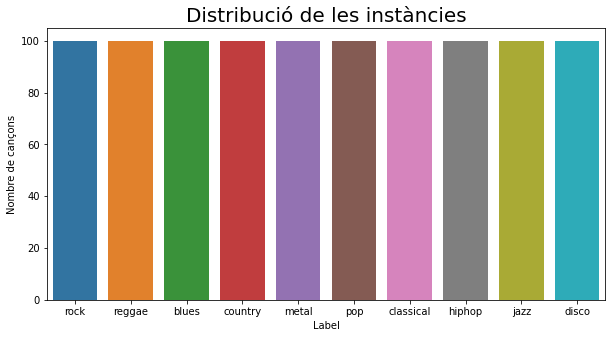

In [8]:
fig_dims=(10,5)
fig, ax = plt.subplots(figsize=fig_dims)

item_counts = DF30["label"].value_counts()
sns.barplot(item_counts.index, item_counts.values)

plt.xlabel("Label");
plt.ylabel("Nombre de cançons");
plt.title("Distribució de les instàncies", fontsize=20);


Aquesta gràfica ens ensenya que les dades estàn perfectament equilibrades, tenint 100 fragments d'audio de cada gènere a classificar i predir


Un punt que s'ha de destacar en la observació de les dades és què s'ha localitzat un arxiu d'àudio pertanyent a la categoria de jazz que sembla que estigui corrupte. Aquest arxiu és `jazz.00054.wav`, que al voler tractar amb aquest ens genera un error d'accés a les seves dades. 

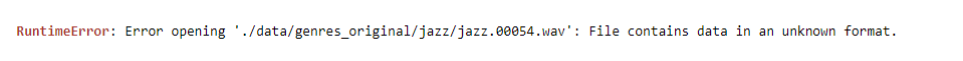

In [51]:
img = mpimg.imread('./data/errorJazz00054.png')
plt.figure(figsize=(17,5))
imgplot = plt.imshow(img)
plt.axis('off')
plt.show();

Aqui veiem el error que ens dóna l'output. Per tal de no comprometre els algorismes i les mesures que veurem a continuació, hem substituït l'arxiu corrupte per un dels altres arxius del mateix gènere i l'hem assignat el mateix nom.

Intentarem mirar ara quina correlació poden tenir els diferents atributs entre ells. Si ens fixem en el dataset que estem estudiant, a la majoria de dades existeixen 2 grups que es refereixen al mateix atribut: var (variància) i mean (mitjana). En el nostre cas la mitjana és el valor que més ens interessa ja que ens dóna molta més informació de les dades a analitzar.

Text(0.5, 1.0, 'Correlation Heatmap (valors Mean)')

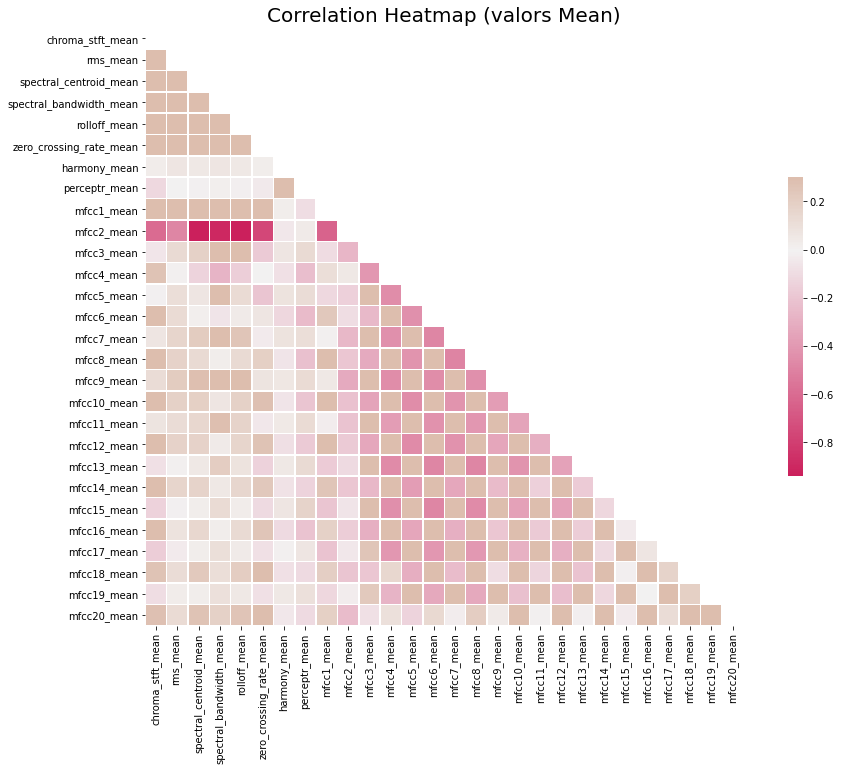

In [71]:
mean_cols = [col for col in DF30.columns if 'mean' in col]
corr = DF30[mean_cols].corr()

mask = np.triu(np.ones_like(corr, dtype=np.bool))

f, ax = plt.subplots(figsize=(16,11));

cmap = sns.diverging_palette(0, 25, as_cmap=True, s = 90, l = 45, n = 5)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title("Correlation Heatmap (valors Mean)", fontsize = 20)

D'aquesta taula podem concloure que hi ha una relació inversa molt gran entre el coeficient 2 del MFCC (Mel Frequency Cepstrum Coefficients), el qual veurem després, i els atributs que no pertanyen a aquest coeficient de Mel com poden ser el Zero Crossing, l'espectre del so, etc.

També podem observar com tots aquest atributs que no tenen a veure amb el coeficient de Mel tenen correlació positiva entre ells.

## Entenent l'àudio

Per entendre millor el nostre Dataset, ens fixarem en un arxiu en concret i veurem com és la seva representació.

In [9]:
audio = "./data/genres_original/metal/metal.00070.wav"

data, sr = librosa.load(audio)

ipd.Audio(data, rate=sr)

Obrim l'arxiu `metal.00070.wav` del nostre dataset que pertany a la cançó **Highway To Hell - AC/DC**

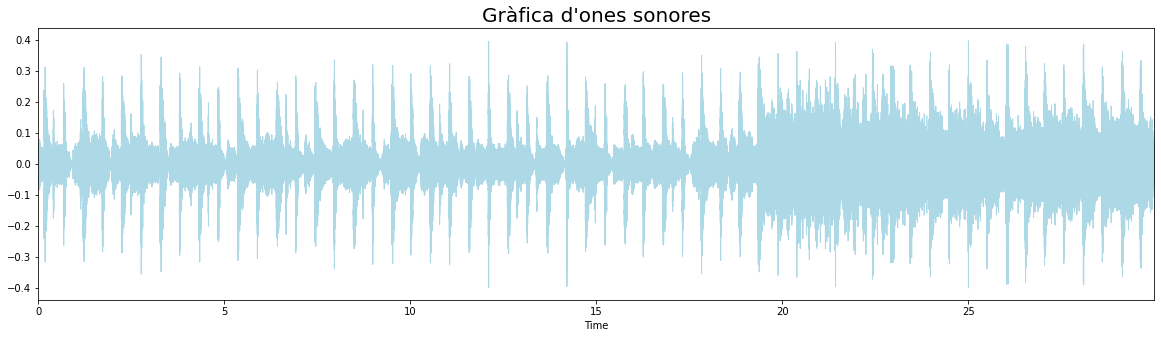

In [10]:
plt.figure(figsize=(20,5))
librosa.display.waveplot(data, color="lightblue")
plt.title("Gràfica d'ones sonores", fontsize=20)
plt.show()

Fem la seva representació visual en 2D. En aquest cas en concret, el so de la bateria quan hi pica és molt notori, marcant uns pics molt característics a la gràfica.

NOTAS:
* __EDA:__
    + Spectograma X
    + Zero-Crossing X
    + Chromagrama X
    + BPM / genre

ERROR JAZZ00054 X


---

#### Spectrograma

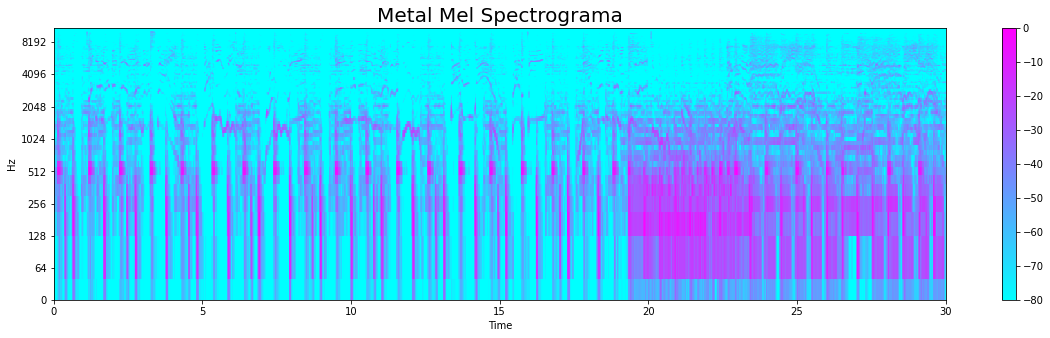

In [11]:
audio = "./data/genres_original/metal/metal.00070.wav"
y, sr = librosa.load(audio)

y, _ = librosa.effects.trim(y)

S = librosa.feature.melspectrogram(y, sr=sr)
S_DB = librosa.amplitude_to_db(S, ref=np.max)
plt.figure(figsize=(20,5))
librosa.display.specshow(S_DB, sr=sr, x_axis='time', y_axis='log', cmap='cool');
plt.colorbar();
plt.title("Metal Mel Spectrograma", fontsize=20);


Amb l'ajuda dels Spectogrames podem analitzar millor les característiques del fragment d'audio. Aquesta representació ens mostra una visió de l'espectre de freqüències de la senyal d'audio, variant a travès del temps.

Anem a comparar-lo amb un Spectrograma d'un fragment de gènere blues.

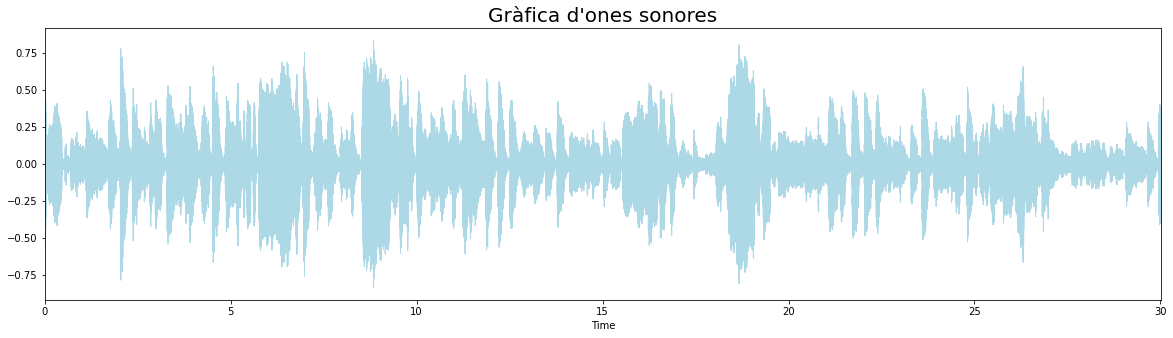

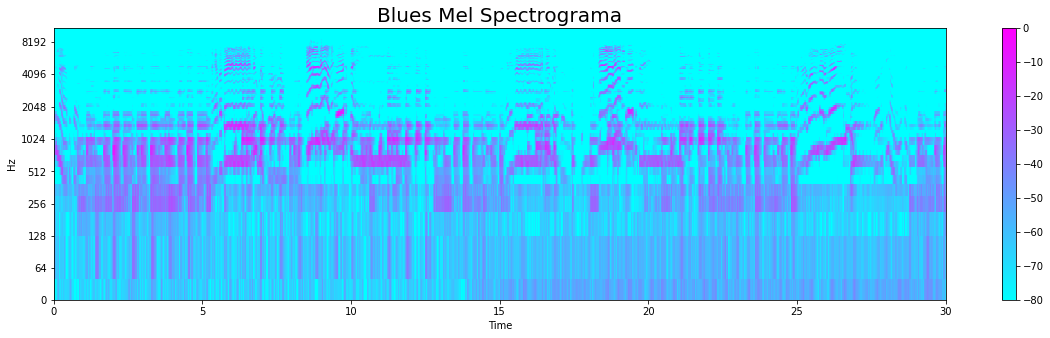

In [12]:
audioBlues = "./data/genres_original/blues/blues.00023.wav"
y, sr = librosa.load(audioBlues)

plt.figure(figsize=(20,5))
librosa.display.waveplot(y, color="lightblue")
plt.title("Gràfica d'ones sonores", fontsize=20)
plt.show()

y, _ = librosa.effects.trim(y)

S = librosa.feature.melspectrogram(y, sr=sr)
S_DB = librosa.amplitude_to_db(S, ref=np.max)
plt.figure(figsize=(20,5))
librosa.display.specshow(S_DB, sr=sr, x_axis='time', y_axis='log', cmap='cool');
plt.colorbar();
plt.title("Blues Mel Spectrograma", fontsize=20);

Veiem la enorme diferència entre un fragment d'audio de gènere metal amb el de blues, on al metal hi ha sons molt estridents i canvis bruscos a més de veus molt altes com podem veure al seu respectiu espectrograma.

En el blues en canvi veiem una gràfica molt més calmada, amb sons més suaus i una veu més tranquil·la.

---

#### Zero Crossing

Una mesura que pot arribar a ser molt útil per tal de classificar quin tipus de música s'està estudiant és el Zero Crossing. Aquesta és una mesura molt simple que es basa en comptar quantes vegades canvia la nostra gràfica d'ones entre negatiu i positiu.

Recordem la nostra gràfica Waveplot:

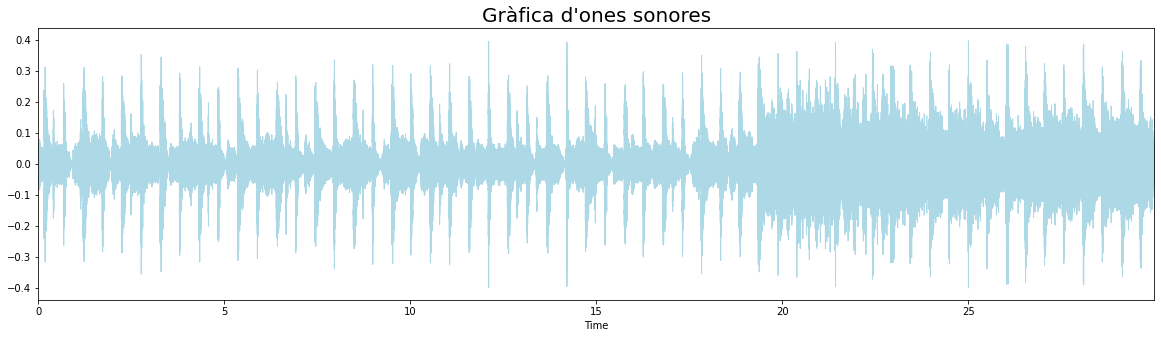

In [13]:
plt.figure(figsize=(20,5))
librosa.display.waveplot(data, color="lightblue")
plt.title("Gràfica d'ones sonores", fontsize=20)
plt.show()

Fent zoom en una regió en concret veurem molt millor representat aquest fenómen.

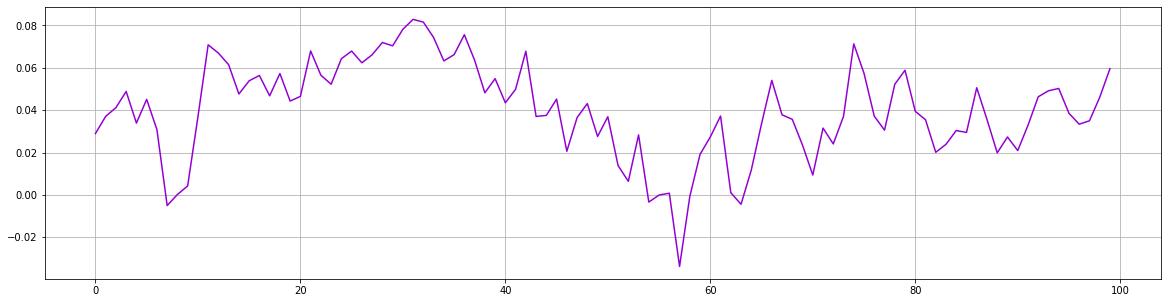

In [14]:
n0 = 9000
n1 = 9100
plt.figure(figsize=(20,5))
plt.plot(data[n0:n1], color="darkviolet")
plt.grid()

En aquesta secció que conforma el fragment `metal.00070.wav` entre el 9000ms i el 9100ms veiem com hi ha 8 zero crossings.

In [15]:
zero_crossings = librosa.zero_crossings(data[n0:n1], pad=False)
print(f"El nombre de zero crossings obtingut per Librosa es: {sum(zero_crossings)}")

El nombre de zero crossings obtingut per Librosa es: 8


Si comparem el nombre total de zero crossings del fragment `metal.00070.wav` amb el de blues previament observat, el `blues.00023.wav` veiem el següent:

In [16]:
y_metal, sr_metal = librosa.load(audio)
y_blues, sr_blues = librosa.load(audioBlues)

zero_crossings_metal = librosa.zero_crossings(y_metal, pad = False)
zero_crossings_blues = librosa.zero_crossings(y_blues, pad = False)

print(f"El nombre de zero crossings del fragment de metal obtingut per Librosa es: {sum(zero_crossings_metal)}")
print(f"El nombre de zero crossings del fragment de blues obtingut per Librosa es: {sum(zero_crossings_blues)}")

El nombre de zero crossings del fragment de metal obtingut per Librosa es: 94659
El nombre de zero crossings del fragment de blues obtingut per Librosa es: 34769


Com podem observar, el valor de zero crossings resultant de tot el fragment del gènere de metal és 3x del nombre de zero crossings del gènere de blues. Aquesta mesura ens ajuda a detectar sons més estridents i bruscos, con es canvia la freqüència molt freqüentment.
Fins ara hem comparat un fragment de cada gènere, però quin resultat ens donaria calcular els zero-crossings de tots els fragments de cada gènere?

In [18]:
zero_crossings_genre = {}
for genre in item_counts.index:
    zero_crossings_genre[genre]=0


for genre in item_counts.index:
    print(f"==================INICI {genre}===========================")
    path = f"./data/genres_original/{genre}/{genre}.000"
    for num in range(0,100):
        idx = str(num).zfill(2)
        pathIdx = path + idx + ".wav"
        y, sr = librosa.load(pathIdx)
        #print(pathIdx)
        zero_crossing=librosa.zero_crossings(y,pad=False)
        #print(zero_crossings_genre[str(genre)])
        zero_crossings_genre[str(genre)] += sum(zero_crossing)
        #print(zero_crossings_genre[genre])
    zero_crossings_genre[genre] /= 100
    print(zero_crossings_genre)
print("=======================FINAL===============================")
print(zero_crossings_genre)

==================INICI rock===========================
{'rock': 72426.01, 'reggae': 0, 'blues': 0, 'country': 0, 'metal': 0, 'pop': 0, 'classical': 0, 'hiphop': 0, 'jazz': 0, 'disco': 0}
==================INICI reggae===========================
{'rock': 72426.01, 'reggae': 60670.89, 'blues': 0, 'country': 0, 'metal': 0, 'pop': 0, 'classical': 0, 'hiphop': 0, 'jazz': 0, 'disco': 0}
==================INICI blues===========================
{'rock': 72426.01, 'reggae': 60670.89, 'blues': 52334.64, 'country': 0, 'metal': 0, 'pop': 0, 'classical': 0, 'hiphop': 0, 'jazz': 0, 'disco': 0}
==================INICI country===========================
{'rock': 72426.01, 'reggae': 60670.89, 'blues': 52334.64, 'country': 55301.37, 'metal': 0, 'pop': 0, 'classical': 0, 'hiphop': 0, 'jazz': 0, 'disco': 0}
==================INICI metal===========================
{'rock': 72426.01, 'reggae': 60670.89, 'blues': 52334.64, 'country': 55301.37, 'metal': 97716.26, 'pop': 0, 'classical': 0, 'hiphop': 0, 'jazz'

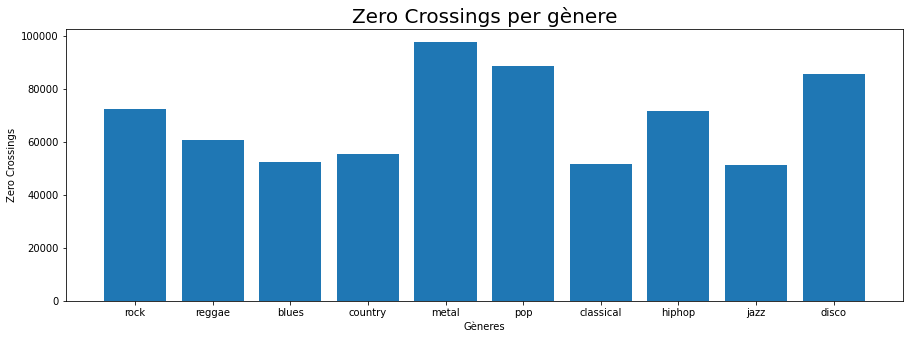

In [37]:
genres=list(zero_crossings_genre.keys())
values=list(zero_crossings_genre.values())

plt.figure(figsize=(15,5))
plt.bar(range(len(zero_crossings_genre)),values)

plt.xticks(np.arange(10),genres[:])
plt.xlabel("Gèneres");
plt.ylabel("Zero Crossings");
plt.title("Zero Crossings per gènere", fontsize=20);
plt.show()

En aquesta gràfica hem calculat tots els Zero Crossings de tots els fragments d'àudio i s'ha fet la mitja de tots els gèneres per així tenir una visió completa del dataset.

Els resultats ens mostren que aquesta mesura és molt útil per diferenciar certs gèneres, on a més valor de zero crossings més estrident i brusca serà la cançó del gènere. En canvi contra menys valor d'aquest valor la música serà més calmada i sense tants altibaixos. 
Amb aquesta mesura podem classificar com a més estridents els gèneres metal, pop i disco amb uns valors màxims de 97k Zero Crossings i com més calmades blues, classical i jazz amb 51k.

---

#### Chromagrama

El Chromagrama és una eina molt potent per analitzar la música que té els pitches ben marcats. Aquesta eina ens ajuda a visualiztar la "forma de la música" i tenir una representació molt visual del que hi ha en un arxiu d'àudio.

Per més informació i el link de la imatge: __https://en.wikipedia.org/wiki/Chroma_feature__ 

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/25/ChromaFeatureCmajorScaleScoreAudioColor.png/1280px-ChromaFeatureCmajorScaleScoreAudioColor.png">

Tornarem a escollir el nostre arxiu de referència `metal.00070.wav` per tal de veure el seu chromagrama.

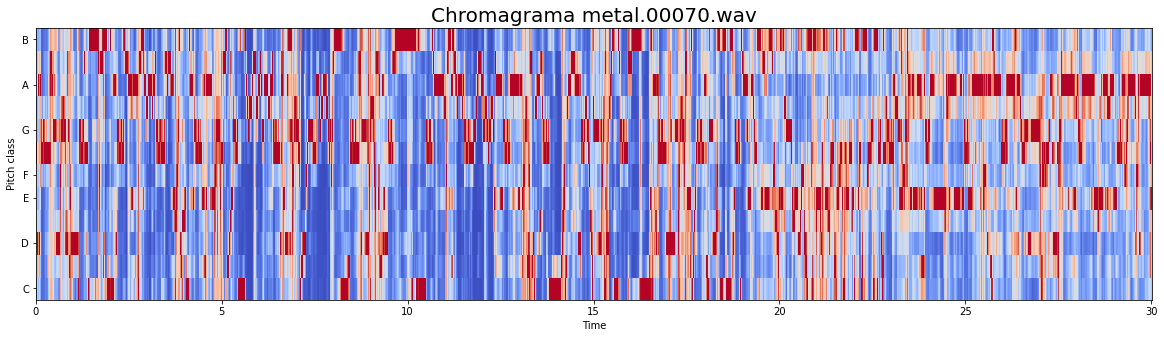

In [67]:
chromagram = librosa.feature.chroma_stft(y_metal, sr_metal)
plt.figure(figsize=(20,5))
plt.title("Chromagrama metal.00070.wav", fontsize=20);
librosa.display.specshow(chromagram, x_axis="time", y_axis="chroma", cmap="coolwarm");

I ho tornarem a comparar amb el mateix arxiu d'abans, `blues.00023.wav`per veure com varia el seu chromagrama.

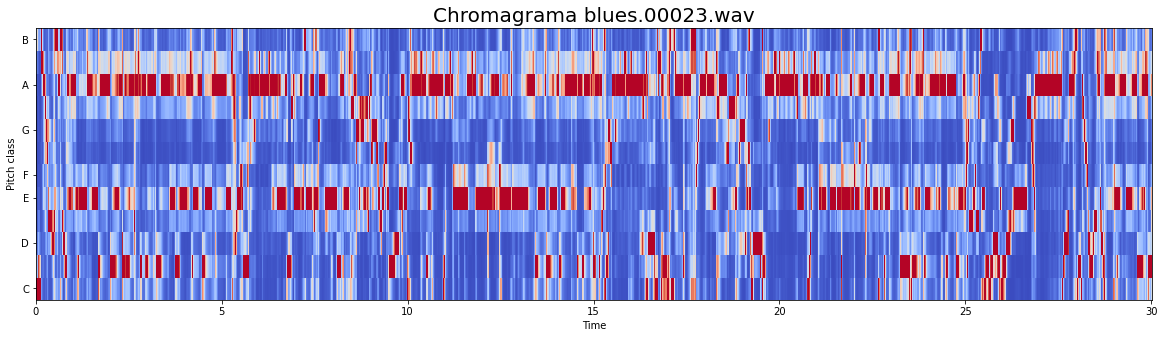

In [69]:
chromagram_blues = librosa.feature.chroma_stft(y_blues, sr_blues)
plt.figure(figsize=(20,5))
plt.title("Chromagrama blues.00023.wav", fontsize=20);
librosa.display.specshow(chromagram_blues, x_axis="time", y_axis="chroma", cmap="coolwarm");

Com s'indica en la llegenda de la primera imatge, contra més vermell més potència té el valor del pitch en concret. Tenint això en compte, veiem com la cançó de metal té una distribució molt més heterogenia i abarca molta gràfica en aquest color vermell tenint una àrea blava molt poc marcada.
En canvi, si ens fixem en el chromagrama del arxiu de blues es veu tot molt més homogeni, sent el vermell molt pur i el blau molt pur. Això ens mostra que la música d'aquest últim gènere no té tantes oscil·lacions i són sons molt més purs, com ja ens havia donat el resultat de l'estudi dels Zero Crossings

---

#### BPM

L'atribut dels BPM (Beats per Minute) és una dada que també ens dóna el dataset i que pot ser molt útil de cara a comparar els diferents gèneres de música entre si.

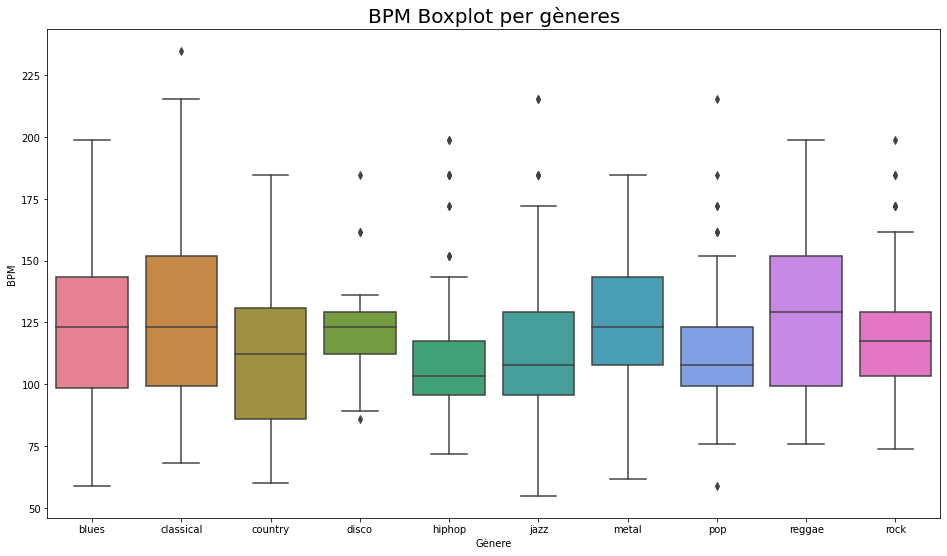

In [73]:
x=DF30[["label","tempo"]]
f, ax = plt.subplots(figsize=(16,9));
sns.boxplot(x="label", y="tempo", data=x, palette="husl")

plt.title("BPM Boxplot per gèneres", fontsize=20);
plt.xlabel("Gènere");
plt.ylabel("BPM");

Segons fonts especialitzades en música, una bona manera de classificar els diferents gèneres de música és diferenciar les seves pulsacions per minut, analitzant així el ritme de la música.

Hi ha certs estàndards en aquestes métriques:

|           | BPM  estàndar | BPM mean (dataset) |
|-----------|:-------------:|:------------------:|
| Blues     |     60-80     |         124        |
| Classical |    120-140    |         124        |
| Country   |    120-130    |         117        |
| Disco     |    115-130    |         125        |
| HipHop    |     85-115    |         107        |
| Jazz      |    120-125    |         111        |
| Metal     |    100-160    |         125        |
| Pop       |    100-130    |         111        |
| Reggae    |     60-90     |         129        |
| Rock      |    110-140    |         123        |

Podem dir llavors que el nostre dataset inclou música "normal" dintre del seu gènere i que entra dintre de la generalització de la seva clase.

### 3. Preprocessing

Com a cada treball de entrenament de models, el nostre dataset ha d'estar normalitzat o estandarditzat. La raó es troba a que els diferents atributs del dataset tenen diferents rangs de valors en les seves dades, pel que estaria molt desvalancejat treballar amb aquestes dades "crudes".

En el nostre conjunt de datasets tenim 2 arxius de dades. Els dos al cap i a la fi tenen les mateixes dades, però el `features_3_sec.csv` té els àudios dividits en arxius de 3 segons cadascun. Aquesta divisió ens aporta una quantitat de dades superior sent les mateixes dades les que estem estudiant, cosa que en el sector de l'aprenentatge computacional sempre és benvingut.

Ens treiem del dataset la columna que ens indica el nom de l'arxiu, no ens serveix per res per entrenar els models.

In [5]:
DF3 = DF3.drop(labels="filename",axis=1)

In [8]:
genre_list = DF3.iloc[:, -1]
encoder = LabelEncoder()

In [9]:
y = encoder.fit_transform(genre_list)

In [16]:
standarizer = StandardScaler()
X = standarizer.fit_transform(np.array(DF3.iloc[:,:-1], dtype=float))

Separem el dataset en train/test en un 33% de test

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33, random_state=42)

Ara que ja hem explorat completament el nostre dataset i tenim un coneixement molt extens, començarem a entrenar models per veure quin funciona millor amb el dataset que estem estudiant. Cal recordar que l'objectiu d'aquest punt és trobar un classificador que ens assigni correctament el gènere de la cançó que seleccionem.